In [121]:
import pandas as pd

In [122]:
# read built dataset
df = pd.read_csv('../../datasets/built_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475428 entries, 0 to 475427
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   item_name                  475428 non-null  object 
 1   category_name              475428 non-null  object 
 2   date                       475428 non-null  object 
 3   time                       475428 non-null  object 
 4   item_code                  475428 non-null  int64  
 5   quantity_sold_kg           475428 non-null  float64
 6   unit_selling_price_rmb/kg  475428 non-null  float64
 7   sale_or_return             475428 non-null  object 
 8   discount                   475428 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 32.6+ MB


In [123]:
# drop non-dependant columns
df = df.drop(columns=['item_code', 'discount'])
df.sample(2)

,item_name,category_name,date,time,quantity_sold_kg,unit_selling_price_rmb/kg,sale_or_return
233650,xixia mushroom,mushroom,2021-10-30,11:51:36.598,0.136,14.0,sale
21657,eggplant,solanum,2021-01-29,19:26:57.875,0.261,10.0,sale


<Axes: >

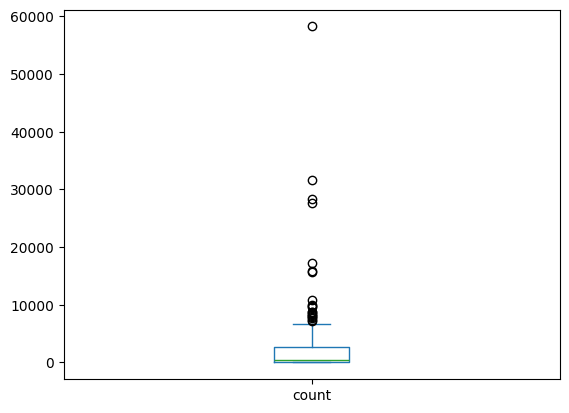

In [124]:
# visualise frequency of selling an item
df['item_name'].value_counts().plot.box()

In [125]:
"""according to the above boxplot there are some items that are sold more than 5000 times. 
    they can be considered as hot selling items and no need to predict a discount on them"""

# drop hot selling items
(df['item_name'].value_counts() > 5000).sum()

28

In [126]:
import numpy as np

In [127]:
# rename top selling items as 'Other'
filt = (df['item_name'].value_counts() > 5000)
df['item_name'] = np.where(filt[df['item_name'].values], 'Other', df['item_name'])
filt = df['item_name'] == 'Other'
df = df.loc[~filt]

df['item_name'].unique().shape[0]

149

<Axes: >

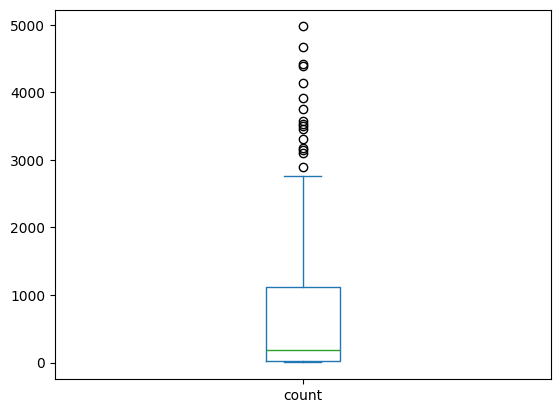

In [128]:
# visualise frequency of selling for rest of items
df['item_name'].value_counts().plot.box()

<Axes: >

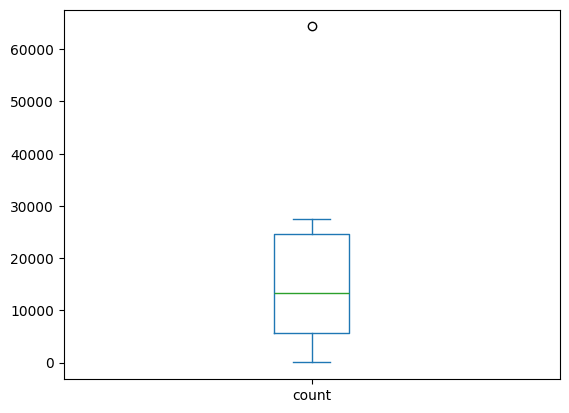

In [129]:
# visualise frequency of selling an category
df['category_name'].value_counts().plot.box()

In [130]:
# check wheather (-) values of sold amount are returned items
(df['quantity_sold_kg'] < 0).sum() == (df['sale_or_return'] == 'return').sum()

True

In [131]:
# remove returned item records
filt = (df['sale_or_return'] == 'return')
df = df.loc[~filt]

df = df.drop(columns=['sale_or_return'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122624 entries, 0 to 475427
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   item_name                  122624 non-null  object 
 1   category_name              122624 non-null  object 
 2   date                       122624 non-null  object 
 3   time                       122624 non-null  object 
 4   quantity_sold_kg           122624 non-null  float64
 5   unit_selling_price_rmb/kg  122624 non-null  float64
dtypes: float64(2), object(4)
memory usage: 6.5+ MB


In [132]:
# check if there are 0 sold amounts
(df['quantity_sold_kg'] == 0).sum()

0

<Axes: >

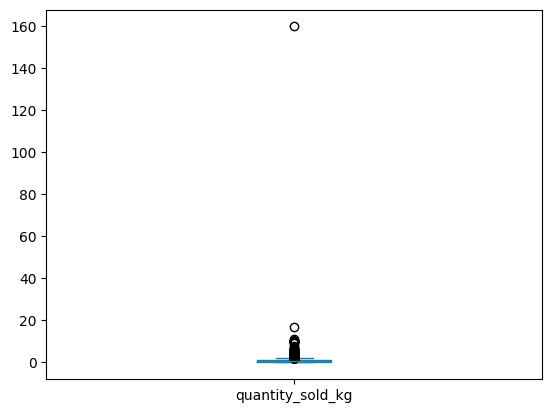

In [133]:
# visualise sold amount
df['quantity_sold_kg'].plot.box()

In [134]:
# check the mean of sold amount
np.mean(df['quantity_sold_kg'])

0.6399339688804803

In [135]:
"""according to the above boxplot there are only few purchases that are sold more than 12.5 kg. in general 12.5 kg is very uncommon to buy in a single time and can consider them as outliers. so handle them with mean values."""

# handle outlier with mean values
filt = df['quantity_sold_kg'] > 12.5
df['quantity_sold_kg'] = np.where(filt, np.mean(df[~filt]['quantity_sold_kg']), df['quantity_sold_kg'])

# check the change of mean
np.mean(df['quantity_sold_kg']), df['quantity_sold_kg'].max()

(0.6385009459966402, 11.0)

<Axes: >

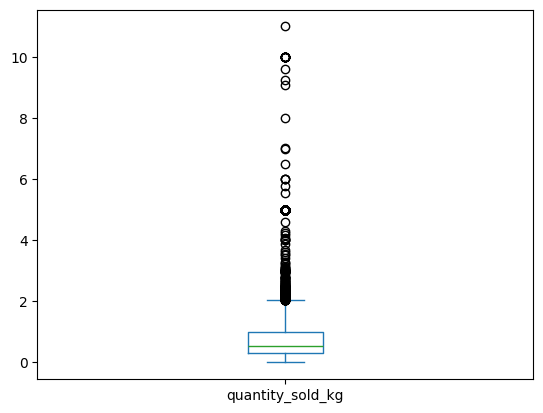

In [136]:
# visualise sold amount
df['quantity_sold_kg'].plot.box()

<Axes: >

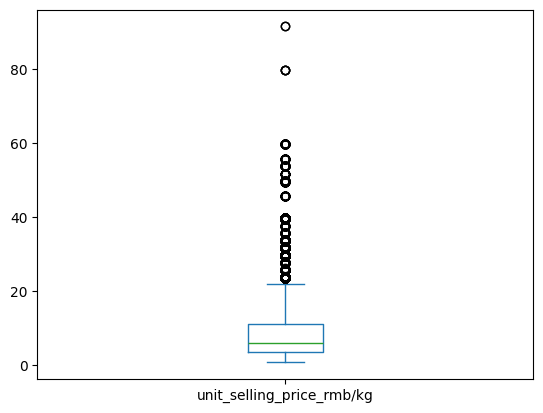

In [137]:
# visualise price
df['unit_selling_price_rmb/kg'].plot.box()

In [138]:
df['time'] = df['time'].str.split(':').str[0].astype(int)

In [139]:
df['time'].head(3)

0    9
1    9
4    9
Name: time, dtype: int64

In [140]:
"""according to the above boxplot there are some items that are sold more than 50 rmb/kg. 
    they can be considered as rare items and by selling very less amount of them aslo can be considered as hot selling. so it is better to not to predict a discount on them"""

# remove rare items
filt = df['unit_selling_price_rmb/kg'] > 50
df = df.loc[~filt]

price = df[['date', 'item_name', 'category_name', 'time', 'unit_selling_price_rmb/kg']]
df = df.drop(columns=['unit_selling_price_rmb/kg'])
price = price.groupby(['date', 'item_name', 'category_name', 'time']).mean().reset_index()

# group dataset by item name, category and date
df = df.groupby(['date', 'item_name', 'category_name', 'time']).sum().reset_index()
df.shape, price.shape

((62356, 5), (62356, 5))

In [141]:
df = df.merge(price, on=['date', 'item_name', 'category_name', 'time'], how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62356 entries, 0 to 62355
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       62356 non-null  object 
 1   item_name                  62356 non-null  object 
 2   category_name              62356 non-null  object 
 3   time                       62356 non-null  int64  
 4   quantity_sold_kg           62356 non-null  float64
 5   unit_selling_price_rmb/kg  62356 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.9+ MB


<Axes: >

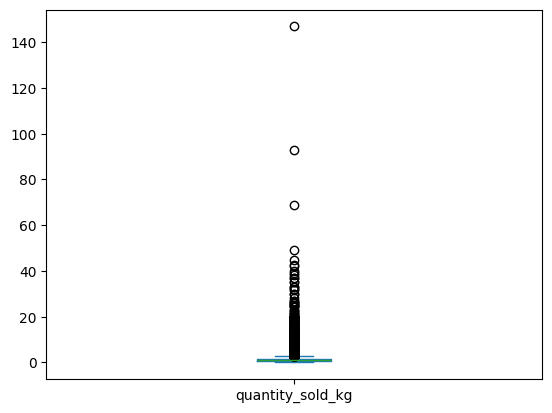

In [142]:
# visualise processed sold amount
df['quantity_sold_kg'].plot.box()

<Axes: >

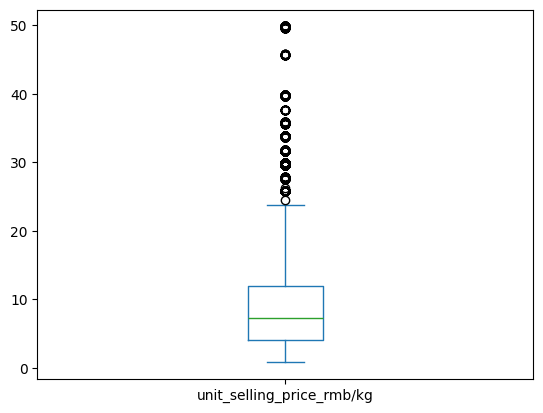

In [144]:
# visualise unit selling price
df['unit_selling_price_rmb/kg'].plot.box()

In [145]:
# view co-relation between price and sold amount
df.loc[:,['unit_selling_price_rmb/kg', 'quantity_sold_kg']].corr()

,unit_selling_price_rmb/kg,quantity_sold_kg
unit_selling_price_rmb/kg,1.000000,-0.416995
quantity_sold_kg,-0.416995,1.000000


<Axes: xlabel='unit_selling_price_rmb/kg', ylabel='quantity_sold_kg'>

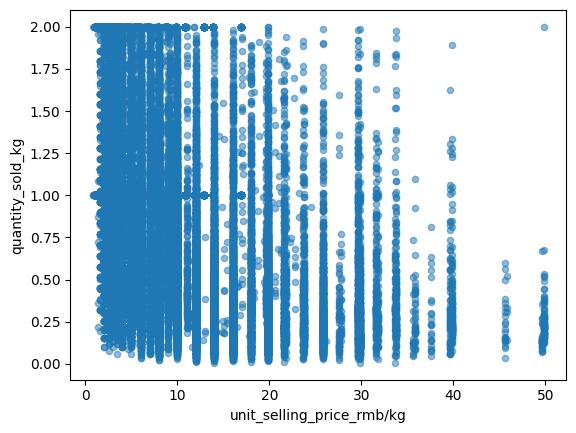

In [146]:
# visualise relation between price and sold amount
df.plot.scatter(x = 'unit_selling_price_rmb/kg', y = 'quantity_sold_kg', alpha = 0.5)

In [ ]:
# one hot encoding
df = pd.get_dummies(df)
df.shape

In [ ]:
df.sample(3)

In [ ]:
# save pre-processed dataset
df.to_csv('pre_processed_dataset.csv', index=False)